### Sending a request to the torchserve encoder service

In [1]:
import httpx
import base64
from PIL import Image
from io import BytesIO
import numpy as np

predict_url="http://127.0.0.1:8080/predictions/sam_vit_h_encode"
pth = "../data/sample-img-fox.jpg"
# reads image as bytes, converts bytes to string so it can be sent as a post request
with open(pth, 'rb') as f:
    byte_string = f.read()
    base64_string = base64.b64encode(byte_string).decode('utf-8')

payload = {"encoded_image": base64_string}

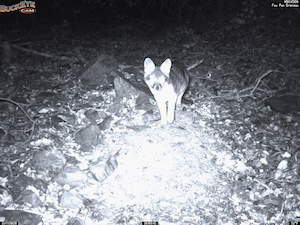

In [2]:
Image.open(pth)

### Time to encode image on 1080 Ti GPU

In [3]:
%%time
response = httpx.post(predict_url, json=payload, timeout=None)

CPU times: user 20.3 ms, sys: 4.15 ms, total: 24.5 ms
Wall time: 1.1 s


### Image embeddings for the image above

In [4]:
encoded_image_string = response.json()['image_embedding']
base64_bytes = base64.b64decode(encoded_image_string)
image_embedding = np.frombuffer(base64_bytes, dtype=np.float32)
image_embedding

array([-0.15134765, -0.11058322, -0.0514493 , ..., -0.03668996,
       -0.04244746, -0.04428473], dtype=float32)